In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import os

sys.path.append('../tools')
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import random

In [3]:
data_dir = "../../../user_data/rns_data"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

In [4]:
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

import pytorch_lightning

pytorch_lightning.utilities.seed.seed_everything(seed=random_seed, workers=True)

Global seed set to 42


42

In [4]:
os.listdir(log_folder_root+'rns_swav_50_all')

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../../../user_data/logs/rns_swav_50_all'

In [8]:
metrics = pd.read_csv(log_folder_root+'rns_active/active_logs_EntropySampling/metrics.csv')

In [12]:
metrics

,train_loss,epoch,step,val_loss,val_acc,val_precision,val_recall,val_f1
0,0.046482,2,49,NaN,NaN,NaN,NaN,NaN
1,NaN,2,49,0.030125,0.836806,0.674572,0.640991,0.637061
2,0.042905,5,99,NaN,NaN,NaN,NaN,NaN
3,NaN,5,99,0.024701,0.872947,0.561421,0.644750,0.580211
4,0.022093,8,149,NaN,NaN,NaN,NaN,NaN
5,NaN,8,149,0.028990,0.840008,0.442332,0.660297,0.511088
6,0.016830,11,199,NaN,NaN,NaN,NaN,NaN
7,NaN,11,199,0.033655,0.789062,0.333904,0.698055,0.429982
8,0.020093,14,249,NaN,NaN,NaN,NaN,NaN
9,NaN,14,249,0.019832,0.916947,0.713808,0.694001,0.694347


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


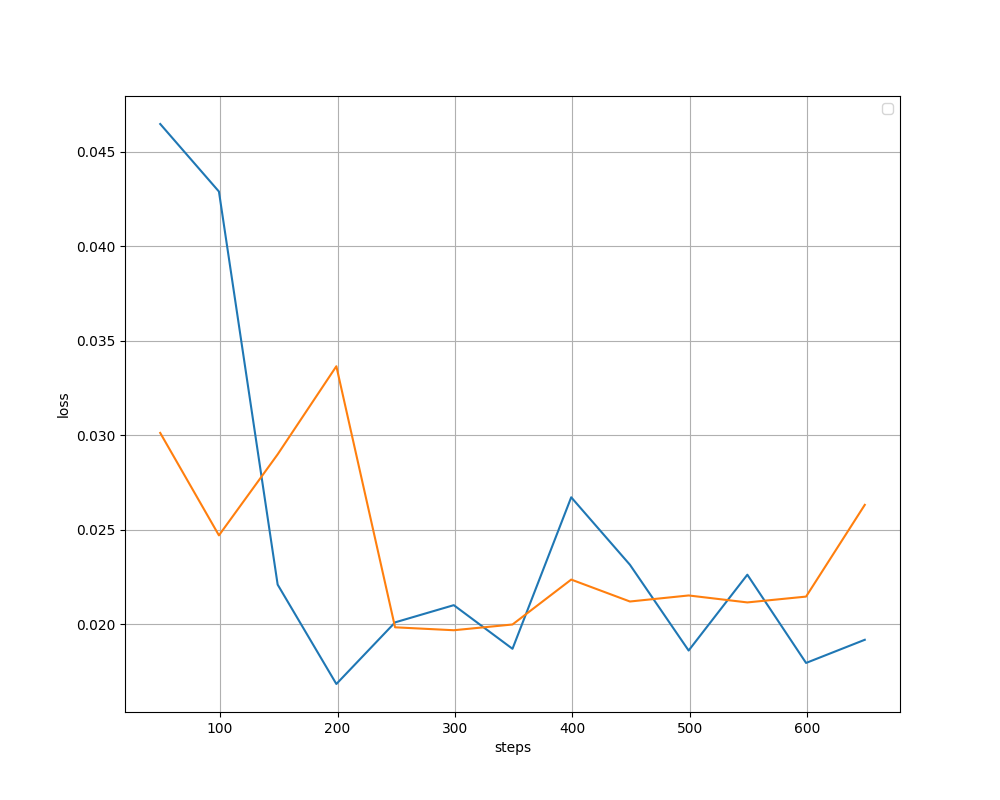

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(metrics.step.unique(),metrics['train_loss'].dropna())
plt.plot(metrics.step.unique(),metrics['val_loss'].dropna())
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [7]:
loss = []
for ep in metrics.epoch.unique():
    loss.append(metrics[metrics.epoch == ep].swav_loss.mean())

In [17]:
loss

[6.7822773635375,
 4.5474022448375,
 4.293776518074999,
 3.6940101861875005,
 3.4501909285875003,
 3.331156286625,
 3.2480690032,
 3.1899357706375,
 3.148222348075,
 3.1149281984567905,
 3.0829030543125002,
 3.073817965375,
 3.0202842504,
 3.0130480348625,
 3.00174531045,
 2.9784669459375,
 2.9618073939625,
 2.9443739294499998,
 2.9386274397375,
 2.9156722904567904,
 2.9248893827374998,
 2.9184851050375,
 2.9018912553874996,
 2.8854286432499996,
 2.8669634998125,
 2.8573880195375,
 2.8595010309999997,
 2.8545121401125,
 2.8396302312625,
 2.826272879123457,
 2.8274315386375,
 2.807897269725,
 2.8247373551375,
 2.8013726686785714]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


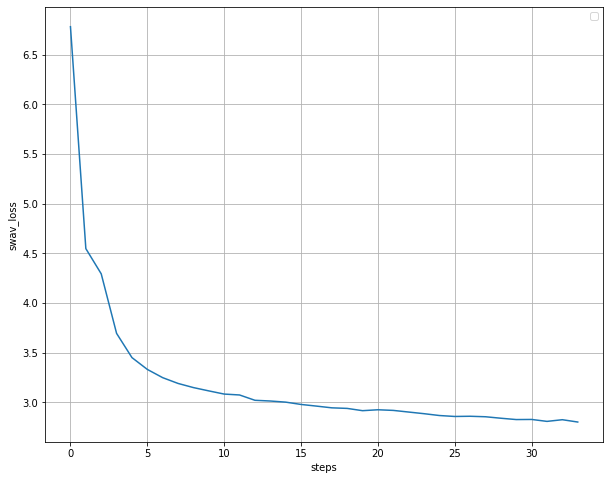

In [19]:
plt.figure(figsize=(10, 8))
plt.plot(metrics.epoch.unique(),loss)
plt.xlabel('steps')
plt.ylabel('swav_loss')
plt.legend()
plt.grid()
plt.show()

In [22]:
final_folder = 'rns_active'
path = os.listdir(log_folder_root+final_folder)
num_round = 11

In [23]:
# path = path[0:3:2]

In [24]:
path

['active_logs_BALDDropout',
 'active_logs_EntropySampling',
 'active_logs_EntropySamplingDropout',
 'active_logs_LeastConfidence',
 'active_logs_LeastConfidenceDropout',
 'active_logs_MarginSampling']

In [25]:

def process_active_loss(path):
    dict = {'val_acc': [],
            'val_precision': [],
            'val_recall': [],
            'val_loss': [],
            }
    for i in range(0, num_round):
        metrics = pd.read_csv(path + '/logger_round_' + str(i) + '/version_0/metrics.csv')
        max_ind = metrics['val_acc'].argmax()
        max_row = metrics.iloc[max_ind]
        dict['val_acc'].append(max_row['val_acc'])
        dict['val_precision'].append(max_row['val_precision'])
        dict['val_recall'].append(max_row['val_recall'])
        dict['val_loss'].append(max_row['val_loss'])
    return dict

query_obj_list = []
for p in path:
    pt = log_folder_root+final_folder+'/' + p
    query_obj_list.append(process_active_loss(pt))

In [26]:
query_obj_list

[{'val_acc': [0.6257433977957996,
   0.8565190268247037,
   0.8272405905593678,
   0.6281971303805365,
   0.9097109586192555,
   0.6281971303805365,
   0.89369931378665,
   0.8956539821168642,
   0.9222707423580786,
   0.6281971303805365,
   0.9322936161364108],
  'val_precision': [0.1406015804975761,
   0.4643280774441632,
   0.5318735756813694,
   0.0,
   0.5406256002279376,
   0.0,
   0.5020592981765309,
   0.5507796173450952,
   0.5454276083822877,
   0.0,
   0.5319942499495794],
  'val_recall': [0.1888160101435477,
   0.5201507695181783,
   0.5027392900931101,
   0.0,
   0.5492716855434427,
   0.0,
   0.5358898301079159,
   0.534496119935146,
   0.5494239173288635,
   0.0,
   0.5707199218105014],
  'val_loss': [0.0543335527181625,
   0.0272482205182313,
   0.0313073582947254,
   0.0575509071350097,
   0.0200466141104698,
   0.0575875230133533,
   0.0221642050892114,
   0.0216919407248497,
   0.0193846803158521,
   0.0574510209262371,
   0.0183285269886255]},
 {'val_acc': [0.622749

In [27]:
import pickle

selected_len = []
for strategy_name in [name.split('_')[-1] for name in path]:

    with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
        selected_inds = pickle.load(f)

    add_size = []
    for key in selected_inds.keys():
        add_size.append(len(selected_inds[key]))
    add_size_cumsum = np.cumsum(add_size)
    selected_len.append(add_size_cumsum/3600)

selected_len = np.vstack(selected_len)


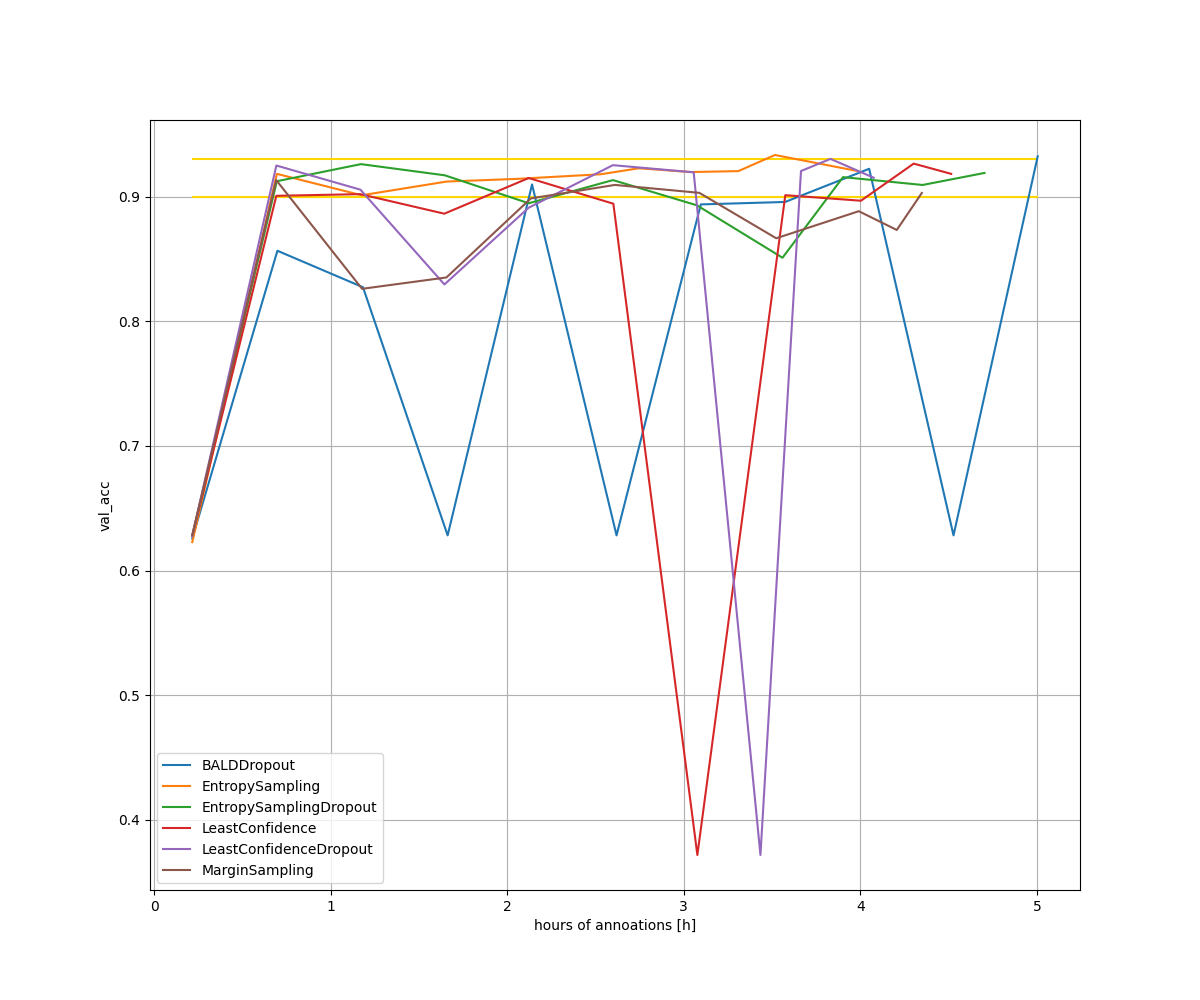

In [28]:
n_samples = 9 + np.arange(0, num_round) * 19

crit = 'val_acc'
plt.figure(figsize=(12, 10))
# plt.plot(n_samples, lcarr1, label='Entropy')
# plt.hlines(0.9014,xmin=0,xmax=n_samples[-1],colors='r')
plt.hlines(0.93,xmin=selected_len.min(),xmax=selected_len.max(),colors='gold')
plt.hlines(0.90,xmin=selected_len.min(),xmax=selected_len.max(),colors='gold')

# plt.plot(n_samples, lcarr2, label='Coreset')
for i in range(len(query_obj_list)):
    plt.plot(selected_len[i][:num_round], query_obj_list[i][crit], label=path[i].split('_')[-1])

# plt.plot(n_samples, vr[crit], label='VarRatio')
plt.xlabel('hours of annoations [h]')
plt.ylabel(crit)
plt.legend()
plt.grid()
plt.show()

In [57]:
add_size_cumsum_arr[0] = np.array([8,71,152,187,281,338,405,462,518,590,635])
add_size_cumsum_arr[1] = np.array([8,26,44,62,80,98,116,134,152,170,187])



array([[  779,  2495,  4220,  5944,  7471,  9184, 10339, 10815, 11660,
        12634, 13165],
       [  779,  1250,  1745,  2193,  2602,  3104,  3953,  5119,  5682,
         6325,  6887],
       [  779,  2496,  4223,  5938,  7675,  9395, 11116, 12844, 14029,
        15447, 16133],
       [  779,  2496,  4223,  5938,  7675,  9395, 11116, 12844, 14029,
        15447, 16133],
       [  779,  2488,  4071,  5647,  7268,  8976, 10682, 12361, 13882,
        15514, 17161]])